导入包

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
os.getcwd()

'g:\\代码\\资产配置项目\\Asset-allocation\\clock'

***这篇研报的核心在于货币周期的划分，将多个和货币周期有关联的变量综合起来，综合方法为将变化数值（连续变量），转为类别变量（1/-1/0），<br>
较好地消除了量纲不一致的问题，鲁棒性较好；报告的信用周期的划分方式为，用社融规模（同比）的过去和未来6个月内的最高/低点。***

# 货币和信用周期分析

## 1. 数据处理过程

### 1.1 货币周期分析
主要处理四类变量:
- 存款准备金率
- 存贷款基准利率
- 公开市场操作（包含央票发行利率、MLF和逆回购利率）
- 货币市场利率（DR007）

**处理步骤：**
1. 将各变量转化为日度信号（1/-1/0）
    - `1` 代表宽松（利率下调）
    - `-1` 代表收紧（利率上调）
    - `0` 代表不变
2. 对日度信号进行月度汇总
3. 生成月度基准信号（存款准备金率 + 存贷款基准利率）
4. 生成最终的月度货币周期指数：
    - 基准信号为 `1/-1` 时，直接采用该值
    - 基准信号为 `0` 时，结合公开市场操作和货币市场利率信号

### 1.2 信用周期分析
基于社会融资规模同比增速划分信用周期：
1. 使用6个月滚动窗口识别局部极值点
2. 最高点到最低点为紧信用周期
3. 最低点到最高点为宽信用周期

### 1.3 货币-信用周期组合
1. 将货币周期和信用周期按月对应
2. 识别四种组合情况：
    - 宽货币-宽信用
    - 宽货币-紧信用
    - 紧货币-宽信用
    - 紧货币-紧信用
3. 统计各组合的时间区间和持续时长

## 2. 主要结果展示
1. 生成货币周期指数曲线图
2. 展示信用周期的转折点分布
3. 形成完整的货币-信用组合周期表，包含：
    - 开始日期
    - 结束日期
    - 周期类型
    - 持续月数

In [2]:
def generate_daily_rates_and_signals(data, date_col, rate_cols, signal_suffix="_signal"):
    '''
    生成日度信号的函数；如，对于准备金率变量，包含大型和中小金融机构的变化，将其用1/-1/0表示；1代表数值降低，经济含义为宽松
    '''
    data[date_col] = pd.to_datetime(data[date_col])
    data = data.sort_values(date_col)
    full_dates = pd.date_range(start=data[date_col].min(), end=data[date_col].max(), freq='D')
    full_data = pd.DataFrame({date_col: full_dates})
    merged_data = full_data.merge(data, on=date_col, how='left')
    for rate_col in rate_cols:
        merged_data[rate_col] = merged_data[rate_col].ffill()

    for rate_col in rate_cols:
        signal_col = rate_col + signal_suffix
        merged_data[signal_col] = 0 
        diff = merged_data[rate_col].diff() 
        merged_data.loc[merged_data[date_col].isin(data[date_col]), signal_col] = diff.apply(
            lambda x: 1 if x < 0 else -1 if x > 0 else 0
        )
    
    return merged_data
 

**存款准备金率日信号处理**

In [3]:
fund_data = pd.read_csv("../data/中国_人民币存款准备金率.csv", encoding='gbk')
date_col_1 = '日期'
fund_rate_cols = ['中国:人民币存款准备金率:中小型存款类金融机构:变动日期', '中国:人民币存款准备金率:大型存款类金融机构:变动日期']
fund_data.columns = [date_col_1] + fund_rate_cols
fund_daily_data = generate_daily_rates_and_signals(fund_data, date_col_1, fund_rate_cols)
fund_daily_data.tail()

,日期,中国:人民币存款准备金率:中小型存款类金融机构:变动日期,中国:人民币存款准备金率:大型存款类金融机构:变动日期,中国:人民币存款准备金率:中小型存款类金融机构:变动日期_signal,中国:人民币存款准备金率:大型存款类金融机构:变动日期_signal
7673,2024-09-23,7.0,10.0,0,0
7674,2024-09-24,7.0,10.0,0,0
7675,2024-09-25,7.0,10.0,0,0
7676,2024-09-26,7.0,10.0,0,0
7677,2024-09-27,6.5,9.5,1,1


**存贷款基准利率日信号处理**

In [4]:
baserate_data = pd.read_csv(r"..\data\中国_存贷款基准利率_1年.csv", encoding='gbk')
date_col_2 = '日期'
baserate_cols = ['中国:存款基准利率:1年', '中国:贷款基准利率:1年']
baserate_data.columns = [date_col_2] + baserate_cols
baserate_data = generate_daily_rates_and_signals(baserate_data, date_col_2, baserate_cols)
baserate_data.tail()

,日期,中国:存款基准利率:1年,中国:贷款基准利率:1年,中国:存款基准利率:1年_signal,中国:贷款基准利率:1年_signal
4008,2015-10-20,1.75,4.60,0,0
4009,2015-10-21,1.75,4.60,0,0
4010,2015-10-22,1.75,4.60,0,0
4011,2015-10-23,1.75,4.60,0,0
4012,2015-10-24,1.50,4.35,1,1


**公开市场操作的日信号处理**

7天逆回购率日信号处理

In [5]:
repo_data = pd.read_csv(r"..\data\中国_逆回购利率_7天.csv", encoding='gbk')
date_col_3 = '日期'
repo_cols = ['中国:逆回购利率:7天']
repo_data.columns = [date_col_3] + repo_cols
repo_data = generate_daily_rates_and_signals(repo_data, date_col_3, repo_cols)
repo_data.tail()

,日期,中国:逆回购利率:7天,中国:逆回购利率:7天_signal
4614,2024-12-20,1.5,0
4615,2024-12-21,1.5,0
4616,2024-12-22,1.5,0
4617,2024-12-23,1.5,0
4618,2024-12-24,1.5,0


1年MLF

In [6]:
mlf_data = pd.read_csv(r"..\data\利率_中期借贷便利(MLF)_1年.csv", encoding='gbk')
date_col_4 = '日期'
mlf_cols = ['利率:中期借贷便利(MLF):1年']
mlf_data.columns = [date_col_4] + mlf_cols
mlf_data = generate_daily_rates_and_signals(mlf_data, date_col_4, mlf_cols)
mlf_data.tail()

,日期,利率:中期借贷便利(MLF):1年,利率:中期借贷便利(MLF):1年_signal
3229,2024-11-21,2.0,0
3230,2024-11-22,2.0,0
3231,2024-11-23,2.0,0
3232,2024-11-24,2.0,0
3233,2024-11-25,2.0,0


央票发行利率处理

In [7]:
def generate_daily_rates_and_signals_symmetric(data, date_col, rate_cols, signal_suffix="_signal"):
    '''
    这同样是生成日度信号的函数，但是阈值改变，应用于DR007和央票发行利率
    '''
    data[date_col] = pd.to_datetime(data[date_col])
    data = data.sort_values(date_col)
    full_dates = pd.date_range(start=data[date_col].min(), end=data[date_col].max(), freq='D')
    full_data = pd.DataFrame({date_col: full_dates})
    merged_data = full_data.merge(data, on=date_col, how='left')

    for rate_col in rate_cols:
        merged_data[rate_col] = merged_data[rate_col].ffill()

    for rate_col in rate_cols:
        signal_col = rate_col + signal_suffix
        merged_data[signal_col] = 0  
        diff = merged_data[rate_col].diff()  
        merged_data.loc[merged_data[date_col].isin(data[date_col]), signal_col] = diff.apply(
            lambda x: 1 if x < -0.05 else -1 if x > 0.05 else 0
        )
    
    signal_cols = [date_col] + [rate_col + signal_suffix for rate_col in rate_cols]
    return merged_data[signal_cols]


In [8]:
#央票利率（3M,6M,1Y,3Y)
face_data = pd.read_csv(r"..\data\中国_发行利率_央行票据.csv", encoding='gbk')
date_col_5 = '日期'
face_cols = ['发行利率:央行票据:3个月', '发行利率:央行票据:1年期', '央行票据:发行利率:6个月', '央行票据:发行利率:3年期']
face_data.columns = [date_col_5] + face_cols
face_data = generate_daily_rates_and_signals_symmetric(face_data, date_col_5, face_cols)
face_data.tail()

,日期,发行利率:央行票据:3个月_signal,发行利率:央行票据:1年期_signal,央行票据:发行利率:6个月_signal,央行票据:发行利率:3年期_signal
7887,2024-11-24,0,0,0,0
7888,2024-11-25,0,0,0,0
7889,2024-11-26,0,0,0,0
7890,2024-11-27,0,0,0,0
7891,2024-11-28,0,0,0,0


**日度信号的月度汇总处理**
：先计算同一一级分项下的日均值，而后按月聚合

In [9]:
def aggregate_monthly_signals(data, date_col, signal_cols, dataset_name="dataset"): 
    '''
    按月份汇总信号数据，返回包含月份和信号汇总值的数据框。
    '''
    data[date_col] = pd.to_datetime(data[date_col])
    
    def calculate_mean_without_zeros(row):
        non_zero_values = row[row != 0]
        return non_zero_values.mean() if len(non_zero_values) > 0 else 0  

    data['daily_mean_signal'] = data[signal_cols].apply(calculate_mean_without_zeros, axis=1)
    data['month'] = data[date_col].dt.to_period('M') 
    monthly_data = data.groupby('month')['daily_mean_signal'].sum().reset_index()
    monthly_data.rename(columns={'daily_mean_signal': f'{dataset_name}月汇总'}, inplace=True)

    return monthly_data

**存款准备金月汇总**

In [10]:
#存款准备金率月汇总
signal_cols = ['中国:人民币存款准备金率:中小型存款类金融机构:变动日期_signal', '中国:人民币存款准备金率:大型存款类金融机构:变动日期_signal']
dataset_name = '存款准备金率'
monthly_data_fund = aggregate_monthly_signals(fund_daily_data, '日期', signal_cols, dataset_name)
monthly_data_fund.head()

,month,存款准备金率月汇总
0,2003-09,0.0
1,2003-10,0.0
2,2003-11,0.0
3,2003-12,0.0
4,2004-01,0.0


**存贷款基准利率月汇总**

In [11]:
#存贷款基准利率月汇总
signal_cols = ['中国:存款基准利率:1年_signal', '中国:贷款基准利率:1年_signal']
dataset_name = '存贷款基准利率'
monthly_data_baserate = aggregate_monthly_signals(baserate_data, '日期', signal_cols, dataset_name)
monthly_data_baserate.head()

,month,存贷款基准利率月汇总
0,2004-10,0.0
1,2004-11,0.0
2,2004-12,0.0
3,2005-01,0.0
4,2005-02,0.0


**公开市场操作月汇总**

央票发行利率月汇总

In [12]:
#央票发行利率月汇总
signal_cols = ['发行利率:央行票据:3个月_signal', '发行利率:央行票据:1年期_signal', '央行票据:发行利率:6个月_signal', '央行票据:发行利率:3年期_signal']
dataset_name = '央票发行利率'
monthly_data_face = aggregate_monthly_signals(face_data, '日期', signal_cols, dataset_name)
monthly_data_face.head()

,month,央票发行利率月汇总
0,2003-04,0.0
1,2003-05,1.0
2,2003-06,-2.0
3,2003-07,-1.0
4,2003-08,-2.0


逆回购率及MLF月汇总

In [13]:
def aggregate_monthly_signals_simple(data, date_col, signal_cols, dataset_name="dataset"):
    '''
    对这两个变量，无需计算均值，直接月度加总    
    '''
    data[date_col] = pd.to_datetime(data[date_col])
    data['daily_signal'] = data[signal_cols]
    data['month'] = data[date_col].dt.to_period('M') 
    monthly_data = data.groupby('month')['daily_signal'].sum().reset_index()
    monthly_data.rename(columns={'daily_signal': f'{dataset_name}月汇总'}, inplace=True)
    return monthly_data

In [14]:
#逆回购率
signal_cols = ['中国:逆回购利率:7天_signal']
dataset_name = '逆回购率'
monthly_data_repo = aggregate_monthly_signals_simple(repo_data, '日期', signal_cols, dataset_name)
monthly_data_repo.head()

,month,逆回购率月汇总
0,2012-05,1
1,2012-06,0
2,2012-07,0
3,2012-08,-1
4,2012-09,1


In [15]:
#MLF月汇总
signal_cols = ['利率:中期借贷便利(MLF):1年_signal']
dataset_name = 'MLF'
monthly_data_mlf = aggregate_monthly_signals_simple(mlf_data, '日期', signal_cols, dataset_name)
monthly_data_mlf.head()

,month,MLF月汇总
0,2016-01,0
1,2016-02,1
2,2016-03,0
3,2016-04,0
4,2016-05,0


央票发行利率 + MLF + 逆回购率 = 公开市场操作月汇总

In [16]:
def combine_monthly_sums(datasets, date_col, sum_cols, combined_col_name="OMO_monthly_sum"):
    combined_data = None

    for dataset, sum_col in zip(datasets, sum_cols):
        dataset[date_col] = dataset[date_col].astype(str)
        dataset[date_col] = pd.to_datetime(dataset[date_col], format="%Y-%m", errors="coerce")

        temp_data = dataset[[date_col, sum_col]].copy()
        temp_data.rename(columns={sum_col: "current_sum"}, inplace=True)

        if combined_data is None:
            combined_data = temp_data.rename(columns={"current_sum": combined_col_name})
        else:
            combined_data = combined_data.merge(temp_data, on=date_col, how='outer')
            combined_data[combined_col_name] = (
                combined_data[combined_col_name].fillna(0) 
                + combined_data["current_sum"].fillna(0)
            )
            combined_data.drop(columns=["current_sum"], inplace=True)

    combined_data = combined_data.sort_values(date_col).reset_index(drop=True)
    return combined_data


datasets = [monthly_data_mlf, monthly_data_repo, monthly_data_face]
date_col = 'month'
sum_cols = ['MLF月汇总', '逆回购率月汇总', '央票发行利率月汇总']  # 每个数据集的月汇总列名不同

omo_monthly_sum = combine_monthly_sums(datasets, date_col, sum_cols, combined_col_name="OMO_monthly_sum")

omo_monthly_sum.head()


,month,OMO_monthly_sum
0,2003-04-01,0.0
1,2003-05-01,1.0
2,2003-06-01,-2.0
3,2003-07-01,-1.0
4,2003-08-01,-2.0


**由月度加总变成月度信号**

In [17]:
def generate_monthly_rates_and_signals(data, date_col, rate_cols, signal_suffix="_signal"):
    '''
    生成月度信号的函数，若月度汇总大于0，则月度信号为1，经济含义为宽松
    '''
    data = data.sort_values(by=date_col).copy()

    for rate_col in rate_cols:
        signal_col = rate_col + signal_suffix

        data[signal_col] = data[rate_col].apply(
            lambda x: 1 if x > 0 else -1 if x < 0 else 0
        )

    return data

月度存款准备金率信号

In [18]:
#存款准备金率月信号
date_col = 'month'
rate_cols = ['存款准备金率月汇总']
fund_monthly_signal = generate_monthly_rates_and_signals(monthly_data_fund, date_col, rate_cols)
fund_monthly_signal.head()

,month,存款准备金率月汇总,存款准备金率月汇总_signal
0,2003-09,0.0,0
1,2003-10,0.0,0
2,2003-11,0.0,0
3,2003-12,0.0,0
4,2004-01,0.0,0


月度存贷款基准利率信号

In [19]:
#存贷款基准利率月信号
date_col = 'month'
rate_cols = ['存贷款基准利率月汇总']
baserate_monthly_signal = generate_monthly_rates_and_signals(monthly_data_baserate, date_col, rate_cols)
baserate_monthly_signal.head()

,month,存贷款基准利率月汇总,存贷款基准利率月汇总_signal
0,2004-10,0.0,0
1,2004-11,0.0,0
2,2004-12,0.0,0
3,2005-01,0.0,0
4,2005-02,0.0,0


月度公开市场操作信号

In [20]:
#公开市场操作月信号
date_col = 'month'
rate_cols = ['OMO_monthly_sum']

omo_monthly_sum["month"] = pd.to_datetime(omo_monthly_sum["month"]) 
omo_monthly_sum["month"] = omo_monthly_sum["month"].dt.to_period("M")
omo_monthly_signal = generate_monthly_rates_and_signals(omo_monthly_sum, date_col, rate_cols)
omo_monthly_signal.tail()

,month,OMO_monthly_sum,OMO_monthly_sum_signal
256,2024-08,0.0,0
257,2024-09,2.0,1
258,2024-10,0.0,0
259,2024-11,0.0,0
260,2024-12,0.0,0


月度货币市场利率信号：该变量前面不需要月度汇总，在这里直接生成月度信号

In [21]:
def generate_monthly_rates_and_signals_symmetric(data, date_col, rate_cols, signal_suffix="_signal"):
  
    data = data.sort_values(by=date_col).copy()

    for rate_col in rate_cols:
        signal_col = rate_col + signal_suffix
        data[signal_col] = 0

        diff_series = data[rate_col].diff()
        data.loc[:, signal_col] = diff_series.apply(
            lambda x: 1 if x < -0.05 else -1 if x > 0.05 else 0
        )

    return data

In [22]:
dr007_monthly_data = pd.read_csv(r"..\data\DR007_monthly.csv", encoding = 'gbk', index_col = 0)
date_col = 'month'
rate_cols = ['DR007']
dr007_monthly_data["month"] = pd.to_datetime(dr007_monthly_data["month"]) 
dr007_monthly_data["month"] = dr007_monthly_data["month"].dt.to_period("M")
dr007_monthly_signal = generate_monthly_rates_and_signals_symmetric(dr007_monthly_data, date_col, rate_cols)

dr007_monthly_signal.head()

,month,DR007,DR007_signal
0,2014-12,4.815731,0
1,2015-01,3.951133,1
2,2015-02,4.595559,-1
3,2015-03,4.411400,1
4,2015-04,2.846471,1


**生成月度基准信号**

依照惯例，先加总-再转为信号；先对月度存款准备金率信号和月度存贷款利率信号进行加总

In [23]:
def combine_monthly_signal_sums(datasets, date_col, sum_cols, combined_col_name="monthly_base_sum"):
    combined_data = None

    for dataset, sum_col in zip(datasets, sum_cols):
        if dataset[date_col].dtype.name == "period[M]":
            dataset[date_col] = dataset[date_col].dt.to_timestamp()
        elif dataset[date_col].dtype == "object":
            dataset[date_col] = pd.to_datetime(dataset[date_col], format="%Y-%m", errors="coerce")

        temp_data = dataset[[date_col, sum_col]].copy()
        temp_data.rename(columns={sum_col: "current_sum"}, inplace=True)

        if combined_data is None:
            combined_data = temp_data.rename(columns={"current_sum": combined_col_name})
        else:
            combined_data = combined_data.merge(temp_data, on=date_col, how='outer')
            combined_data[combined_col_name] = (
                combined_data[combined_col_name].fillna(0) 
                + combined_data["current_sum"].fillna(0)
            )
            combined_data.drop(columns=["current_sum"], inplace=True)

    combined_data = combined_data.sort_values(date_col).reset_index(drop=True)
    return combined_data


datasets = [fund_monthly_signal, baserate_monthly_signal]
date_col = 'month'
sum_cols = ['存款准备金率月汇总_signal', '存贷款基准利率月汇总_signal']  

pre_monthly_base_signal = combine_monthly_signal_sums(datasets, date_col, sum_cols, combined_col_name="pre_monthly_base_signal")
pre_monthly_base_signal["month"] = pre_monthly_base_signal["month"].dt.to_period("M")


pre_monthly_base_signal.tail()


,month,pre_monthly_base_signal
248,2024-05,0.0
249,2024-06,0.0
250,2024-07,0.0
251,2024-08,0.0
252,2024-09,1.0


转为信号

In [24]:
def generate_base_signals(data, date_col, rate_cols, signal_suffix="_final"):
    '''
    生成基准信号的函数，若月度加总大于0，则信号为1，经济含义为宽松
    '''

    data = data.sort_values(by=date_col).copy()

    for rate_col in rate_cols:
        signal_col = rate_col + signal_suffix
        data[signal_col] = data[rate_col].apply(
            lambda x: 1 if x > 0 else -1 if x < 0 else 0
        )

    return data

In [25]:
#月度基准信号
date_col = 'month'
rate_cols = ['pre_monthly_base_signal']
monthly_base_signal = generate_base_signals(pre_monthly_base_signal, date_col, rate_cols)
monthly_base_signal.head()

,month,pre_monthly_base_signal,pre_monthly_base_signal_final
0,2003-09,0.0,0
1,2003-10,0.0,0
2,2003-11,0.0,0
3,2003-12,0.0,0
4,2004-01,0.0,0


In [26]:
def update_signals_based_on_events(events_data, signal_data, date_col, signal_col, event_col, start_date_col, event_signal_map):

    events_data[start_date_col] = pd.to_datetime(events_data[start_date_col]).dt.to_period('M')
    events_data['信号值'] = events_data[event_col].map(event_signal_map)
    if not pd.api.types.is_period_dtype(signal_data[date_col]):
        signal_data[date_col] = pd.to_datetime(signal_data[date_col]).dt.to_period('M')
    for _, row in events_data.iterrows():
        event_date = row[start_date_col]
        event_signal = row['信号值']
        if event_date in signal_data[date_col].values:
            signal_data.loc[signal_data[date_col] == event_date, signal_col] = event_signal

    return signal_data

**主观信号**

In [27]:
events_data = pd.read_csv(r"..\data\主观信号.csv", encoding='gbk')

event_signal_map = {
    "定向降准": 1,
    "货币市场利率": -1
}


updated_monthly_base_signal = update_signals_based_on_events(
    events_data=events_data,
    signal_data=monthly_base_signal,
    date_col='month',
    signal_col='pre_monthly_base_signal_final',
    event_col='事件',
    start_date_col='开始日期',
    event_signal_map=event_signal_map
)

updated_monthly_base_signal.tail()



C:\Users\Hosen\AppData\Local\Temp\ipykernel_12764\4008096292.py:5: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(signal_data[date_col]):


,month,pre_monthly_base_signal,pre_monthly_base_signal_final
248,2024-05,0.0,0
249,2024-06,0.0,0
250,2024-07,0.0,0
251,2024-08,0.0,0
252,2024-09,1.0,1


***月度货币周期指数***

In [28]:
def calculate_monthly_monetary_cycle_index(
    base_data: pd.DataFrame,
    open_market_data: pd.DataFrame,
    market_rate_data: pd.DataFrame,
    date_col: str,
    base_signal_col: str,
    open_market_signal_col: str,
    market_rate_signal_col: str
):
    """
    根据如下规则计算月度货币周期指数：
      - 当月基准信号为 +1/-1 时，指数直接为 +1/-1；
      - 当月基准信号为 0 时，指数 = 上月指数 + 公开市场操作信号/3 + 利率信号/3。
    """
    
    if pd.api.types.is_period_dtype(base_data[date_col]):
        base_data[date_col] = base_data[date_col].dt.to_timestamp(how="start")
    if pd.api.types.is_period_dtype(open_market_data[date_col]):
        open_market_data[date_col] = open_market_data[date_col].dt.to_timestamp(how="start")
    if pd.api.types.is_period_dtype(market_rate_data[date_col]):
        market_rate_data[date_col] = market_rate_data[date_col].dt.to_timestamp(how="start")
    df = (
        base_data.set_index(date_col)[[base_signal_col]]
        .join(open_market_data.set_index(date_col)[[open_market_signal_col]], how='outer')
        .join(market_rate_data.set_index(date_col)[[market_rate_signal_col]], how='outer')
        .sort_index()
    )
    
    df[[base_signal_col, open_market_signal_col, market_rate_signal_col]] = df[
        [base_signal_col, open_market_signal_col, market_rate_signal_col]
    ].fillna(0)

    df["monetary_cycle_index"] = pd.NA
    
    dates = df.index.unique().sort_values()
    
    first_month = dates[0]
    first_base_signal = df.at[first_month, base_signal_col]
    if first_base_signal == 1:
        df.at[first_month, "monetary_cycle_index"] = 1
    elif first_base_signal == -1:
        df.at[first_month, "monetary_cycle_index"] = -1
    else:
        df.at[first_month, "monetary_cycle_index"] = 0

    for t in range(1, len(dates)):
        current_date = dates[t]
        prev_date = dates[t - 1]

        b_signal = df.at[current_date, base_signal_col]
        o_signal = df.at[current_date, open_market_signal_col]
        r_signal = df.at[current_date, market_rate_signal_col]

        prev_index_val = df.at[prev_date, "monetary_cycle_index"]

        if b_signal == 1:
            df.at[current_date, "monetary_cycle_index"] = 1
        elif b_signal == -1:
            df.at[current_date, "monetary_cycle_index"] = -1
        else:
            df.at[current_date, "monetary_cycle_index"] = prev_index_val + o_signal / 3 + r_signal / 3
    
    result = df.reset_index()[[date_col, "monetary_cycle_index"]].copy()
    return result


In [29]:
monetary_cycle_index = calculate_monthly_monetary_cycle_index(
    base_data=updated_monthly_base_signal,
    open_market_data=omo_monthly_signal,
    market_rate_data=dr007_monthly_signal,
    date_col="month",
    base_signal_col="pre_monthly_base_signal_final",
    open_market_signal_col="OMO_monthly_sum_signal",
    market_rate_signal_col="DR007_signal"
)
monetary_cycle_index.tail()

C:\Users\Hosen\AppData\Local\Temp\ipykernel_12764\3336156166.py:16: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(base_data[date_col]):
C:\Users\Hosen\AppData\Local\Temp\ipykernel_12764\3336156166.py:18: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(open_market_data[date_col]):
C:\Users\Hosen\AppData\Local\Temp\ipykernel_12764\3336156166.py:20: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(market_rate_data[date_col]):


,month,monetary_cycle_index
256,2024-08-01,1.333333
257,2024-09-01,1
258,2024-10-01,1.333333
259,2024-11-01,1.333333
260,2024-12-01,1.333333


***货币周期划分*** 货币周期指数>0则为宽周期，<0则为紧周期，=0为中性

In [30]:
df = monetary_cycle_index.sort_values("month").reset_index(drop=True)

df["cycle_phase"] = np.select(
    [
        df["monetary_cycle_index"] > 0,
        df["monetary_cycle_index"] < 0
    ],
    [
        "宽周期",
        "紧周期"
    ],
    default="中性"
)

df.head()

,month,monetary_cycle_index,cycle_phase
0,2003-04-01,0,中性
1,2003-05-01,0.333333,宽周期
2,2003-06-01,0.0,中性
3,2003-07-01,-0.333333,紧周期
4,2003-08-01,-0.666667,紧周期


In [31]:
df["phase_change"] = df["cycle_phase"] != df["cycle_phase"].shift(1)
df["group_id"] = df["phase_change"].cumsum()
grouped = df.groupby("group_id", as_index=False).agg(
    start_month=("month", "min"),
    end_month=("month", "max"),
    cycle_phase=("cycle_phase", "first"),
    duration=("month", "count")
)
for i in range(1, len(grouped)):
    if grouped.loc[i, "duration"] <= 1:
        grouped.loc[i - 1, "end_month"] = grouped.loc[i, "end_month"]
        grouped.loc[i - 1, "cycle_phase"] = grouped.loc[i - 1, "cycle_phase"]
        grouped.loc[i, "delete"] = True
grouped["delete"] = grouped["delete"].fillna(False)
grouped = grouped[grouped["delete"] == False].reset_index(drop=True)
grouped = grouped.drop(columns=["delete"])
merged_grouped = []
for i, row in grouped.iterrows():
    if i == 0:
        merged_grouped.append(row)
    else:
        if row["cycle_phase"] == merged_grouped[-1]["cycle_phase"]:
            merged_grouped[-1]["end_month"] = row["end_month"]
            merged_grouped[-1]["duration"] += row["duration"]
        else:
            merged_grouped.append(row)
grouped = pd.DataFrame(merged_grouped)
grouped['start_month'] = grouped['start_month'].dt.strftime('%Y-%m')
grouped['end_month'] = grouped['end_month'].dt.strftime('%Y-%m')

grouped

C:\Users\Hosen\AppData\Local\Temp\ipykernel_12764\3477662717.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  grouped.loc[i, "delete"] = True


,group_id,start_month,end_month,cycle_phase,duration
0,1,2003-04,2003-05,中性,1
1,4,2003-07,2005-06,紧周期,24
2,5,2005-07,2006-03,宽周期,8
4,8,2006-04,2008-08,紧周期,29
5,9,2008-09,2009-12,宽周期,16
6,10,2010-01,2011-11,紧周期,23
7,11,2011-12,2013-05,宽周期,18
8,12,2013-06,2014-03,紧周期,10
9,13,2014-04,2017-01,宽周期,34
10,14,2017-02,2017-12,紧周期,11


可视化货币周期区间

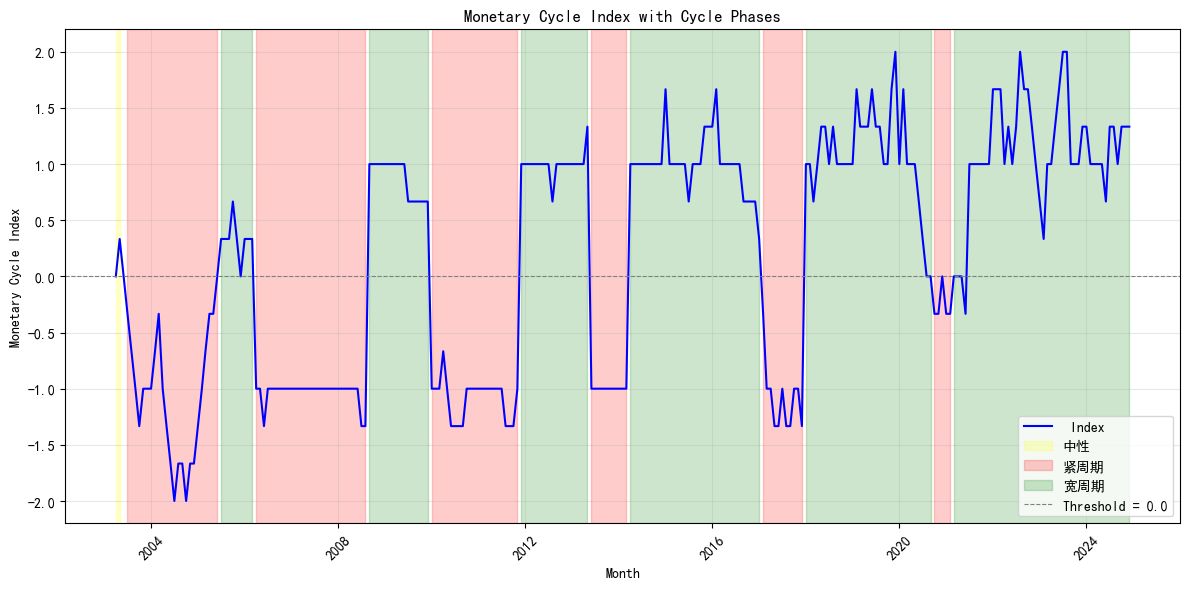

In [32]:
plt.figure(figsize=(12, 6))

plt.plot(df["month"], df["monetary_cycle_index"], label=" Index", color="blue", linewidth=1.5)

for _, row in grouped.iterrows():
    start_date = row["start_month"]
    end_date = row["end_month"]
    cycle_phase = row["cycle_phase"]
    
    if cycle_phase == "宽周期":
        color = "green"
    elif cycle_phase == "紧周期":
        color = "red"
    else:
        color = "yellow" 
    
    plt.axvspan(
        start_date,
        end_date,
        color=color,
        alpha=0.2,
        label=cycle_phase if plt.gca().get_legend_handles_labels()[1].count(cycle_phase) == 0 else None  # 避免重复图例
    )

plt.axhline(0.0, color="gray", linestyle="--", linewidth=0.8, label="Threshold = 0.0")
plt.xticks(rotation=45)  
plt.xlabel("Month")
plt.ylabel("Monetary Cycle Index")
plt.title("Monetary Cycle Index with Cycle Phases")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


***信用周期*** <br>

In [33]:
social_df = pd.read_csv(r'..\data\中国_社会融资规模_当月值.csv', encoding='gbk')[4:-1]
social_df.columns = ['date', 'value']
social_df['date'] = pd.to_datetime(social_df['date'])
social_df['value'] = social_df['value'].astype(float)
social_df = social_df.reset_index(drop=True)
social_df['pct'] = social_df['value'].pct_change(12)
social_df

,date,value,pct
0,2002-01-31,-472.0,NaN
1,2002-02-28,289.0,NaN
2,2002-03-31,3136.0,NaN
3,2002-04-30,1151.0,NaN
4,2002-05-31,1774.0,NaN
...,...,...,...
269,2024-06-30,32985.0,-0.219567
270,2024-07-31,7707.0,0.436265
271,2024-08-31,30323.0,-0.030564
272,2024-09-30,37635.0,-0.089314


In [34]:
df = social_df.copy()
df.rename(columns={'pct': 'social_financing'}, inplace=True)
df.set_index('date', inplace=True)

# 定义滑动窗口函数，判断是否是前后6个月的最小值或最大值
def is_local_extreme(series, window=6, mode='min'):
    if mode == 'min':
        rolling_extreme = series.rolling(window=2*window+1, center=True).min()
    elif mode == 'max':
        rolling_extreme = series.rolling(window=2*window+1, center=True).max()
    else:
        raise ValueError("Invalid mode! Use 'min' or 'max'.")
    return series == rolling_extreme

# 使用滚动窗口确定局部低点和高点
window_size = 6
df['is_min'] = is_local_extreme(df['social_financing'], window=window_size, mode='min').astype(int)
df['is_max'] = is_local_extreme(df['social_financing'], window=window_size, mode='max').astype(int)

# 新建一列，标记局部最低点和最高点
# 标记规则：1 表示局部最低，-1 表示局部最高，0 表示非极值
df['extreme'] = 0
df.loc[df['is_min'] == 1, 'extreme'] = 1
df.loc[df['is_max'] == 1, 'extreme'] = -1

# 修正逻辑：消除连续相同类型的极值，保留最后一个
next_value = 0  # 用于记录下一次出现的有效值
for idx in reversed(df.index):  # 反向遍历 DataFrame
    current_value = df.loc[idx, 'extreme']
    if current_value == 0:
        continue
    if current_value == next_value:  # 如果与下一次出现的值相同，则重置为非极值
        df.loc[idx, 'extreme'] = 0
    else:
        next_value = current_value  # 更新下一次的有效值

# 删除临时列
df.drop(columns=['is_min', 'is_max'], inplace=True)

# 标记宽信用和紧信用区间
df['credit_cycle'] = 0  # 默认宽信用区间标记为 0
tight_credit_periods = []  # 紧信用区间时间段
wide_credit_periods = []  # 宽信用区间时间段

in_tight_credit = False  # 是否处于紧信用区间
start_date = None  # 记录当前区间的开始时间

for idx, row in df.iterrows():
    if row['extreme'] == -1:  # 遇到局部最高点，进入紧信用区间
        if not in_tight_credit:  # 如果之前是宽信用区间，记录宽信用区间的结束
            if start_date is not None:
                wide_credit_periods.append((start_date, idx))  # 记录宽信用区间
        in_tight_credit = True
        start_date = idx  # 记录紧信用区间的开始时间
    elif row['extreme'] == 1:  # 遇到局部最低点，退出紧信用区间
        if in_tight_credit:  # 如果之前是紧信用区间，记录紧信用区间的结束
            tight_credit_periods.append((start_date, idx))  # 记录紧信用区间
        in_tight_credit = False
        start_date = idx  # 记录宽信用区间的开始时间

# 如果最后一个区间未结束，补充记录
if in_tight_credit:
    tight_credit_periods.append((start_date, df.index[-1]))
else:
    wide_credit_periods.append((start_date, df.index[-1]))

tight_credit_df = pd.DataFrame(tight_credit_periods, columns=['start_date', 'end_date'])
wide_credit_df = pd.DataFrame(wide_credit_periods, columns=['start_date', 'end_date'])

tight_credit_df['credit_cycle'] = '紧信用'
wide_credit_df['credit_cycle'] = '宽信用'

credit_periods_df = pd.concat([tight_credit_df, wide_credit_df], ignore_index=True)

credit_periods_df.sort_values(by='start_date', inplace=True)

credit_periods_df

,start_date,end_date,credit_cycle
13,2004-02-29,2004-03-31,宽信用
0,2004-03-31,2004-10-31,紧信用
14,2004-10-31,2005-02-28,宽信用
1,2005-02-28,2005-10-31,紧信用
15,2005-10-31,2006-07-31,宽信用
2,2006-07-31,2006-10-31,紧信用
16,2006-10-31,2007-10-31,宽信用
3,2007-10-31,2008-10-31,紧信用
17,2008-10-31,2009-10-31,宽信用
4,2009-10-31,2011-09-30,紧信用


可视化信用周期

In [35]:
import plotly.express as px

df_reset = df.reset_index()

# 添加标记列（用于区分高点和低点）
df_reset['extreme_type'] = df_reset['extreme'].map({1: 'Local Minima', -1: 'Local Maxima'})

# 过滤出局部极值
extremes = df_reset[df_reset['extreme'] != 0]

# 绘制交互式图表
fig = px.line(df_reset, x='date', y='social_financing', title='Social Financing with Local Extremes',
              labels={'social_financing': 'Social Financing', 'date': 'Date'})

# 添加局部低点
fig.add_scatter(x=extremes[extremes['extreme'] == 1]['date'],
                y=extremes[extremes['extreme'] == 1]['social_financing'],
                mode='markers', name='Local Minima', marker=dict(color='red', size=10))

# 添加局部高点
fig.add_scatter(x=extremes[extremes['extreme'] == -1]['date'],
                y=extremes[extremes['extreme'] == -1]['social_financing'],
                mode='markers', name='Local Maxima', marker=dict(color='green', size=10))

fig.show()

***整合货币和信用周期***

In [36]:
# 先将两个df整合
df1 = grouped
df2 = credit_periods_df

df1['start_date'] = pd.to_datetime(df1['start_month'])
df1['end_date'] = pd.to_datetime(df1['end_month'])
df2['start_date'] = pd.to_datetime(df2['start_date'])
df2['end_date'] = pd.to_datetime(df2['end_date'])

def split_into_months(start, end, period_name):
    """按月拆分时间区间"""
    dates = pd.date_range(start, end, freq='MS')
    return pd.DataFrame({'月份': dates, '周期': period_name})

split_df1 = pd.concat([split_into_months(row['start_date'], row['end_date'], row['cycle_phase']) for _, row in df1.iterrows()])
split_df2 = pd.concat([split_into_months(row['start_date'], row['end_date'], row['credit_cycle']) for _, row in df2.iterrows()])

combined_df = pd.merge(split_df1, split_df2, on='月份', how='inner')

combined_df.rename(columns={'周期_x': '货币周期', '周期_y': '信用周期'}, inplace=True)

combined_df


,月份,货币周期,信用周期
0,2004-03-01,紧周期,宽信用
1,2004-04-01,紧周期,紧信用
2,2004-05-01,紧周期,紧信用
3,2004-06-01,紧周期,紧信用
4,2004-07-01,紧周期,紧信用
...,...,...,...
243,2024-06-01,宽周期,宽信用
244,2024-07-01,宽周期,宽信用
245,2024-08-01,宽周期,宽信用
246,2024-09-01,宽周期,宽信用


In [37]:
# 再按照区间进行整合
def aggregate_to_intervals(df):
    """
    将逐月数据合并为区间形式，输出开始日期、结束日期、货币-信用周期、时长。
    """
    df = df.sort_values('月份').reset_index(drop=True)

    intervals = []
    start_date = df.loc[0, '月份']
    current_cycle = f"{df.loc[0, '信用周期'].replace('紧周期', '紧货币').replace('宽周期', '宽货币')}-" \
                    f"{df.loc[0, '货币周期'].replace('紧周期', '紧货币').replace('宽周期', '宽货币')}"
    duration = 1

    for i in range(1, len(df)):
        cycle = f"{df.loc[i, '信用周期'].replace('紧周期', '紧货币').replace('宽周期', '宽货币')}-" \
                f"{df.loc[i, '货币周期'].replace('紧周期', '紧货币').replace('宽周期', '宽货币')}"
        if cycle == current_cycle:
            duration += 1
        else:
            intervals.append({
                '开始日期': start_date.strftime('%Y-%m'),
                '结束日期': df.loc[i-1, '月份'].strftime('%Y-%m'),
                '货币-信用周期': current_cycle,
                '时长(月)': duration
            })
            start_date = df.loc[i, '月份']
            current_cycle = cycle
            duration = 1
    
    intervals.append({
        '开始日期': start_date.strftime('%Y-%m'),
        '结束日期': df.loc[len(df)-1, '月份'].strftime('%Y-%m'),
        '货币-信用周期': current_cycle,
        '时长(月)': duration
    })

    return pd.DataFrame(intervals)

result_df = aggregate_to_intervals(combined_df)

result_df

,开始日期,结束日期,货币-信用周期,时长(月)
0,2004-03,2004-03,宽信用-紧货币,1
1,2004-04,2004-10,紧信用-紧货币,7
2,2004-11,2005-02,宽信用-紧货币,4
3,2005-03,2005-06,紧信用-紧货币,4
4,2005-07,2005-10,紧信用-宽货币,4
5,2005-11,2006-03,宽信用-宽货币,5
6,2006-04,2006-07,宽信用-紧货币,4
7,2006-08,2006-10,紧信用-紧货币,3
8,2006-11,2007-10,宽信用-紧货币,12
9,2007-11,2008-08,紧信用-紧货币,10


***下面进行一下各区间收益率的对比***

后面会将这部分代码独立出来，这里先进行一下测算

In [38]:
cycle = result_df
bond = pd.read_csv(r"..\data\中债全价指数_clean.csv")
stock = pd.read_csv(r"..\data\沪深300_clean.csv")
ca_future = pd.read_csv(r"..\data\CA.LME_cleannnn.csv")
hj_future = pd.read_csv(r"..\data\期货收盘价(连续)_COMEX黄金_clean.csv", encoding = 'gbk')
yy_future = pd.read_csv(r"..\data\期货结算价(连续)_布伦特原油_clean.csv", encoding = 'gbk')

In [39]:
# 计算每个货币-信用周期内各资产的累计收益率
cycle["开始日期"] = pd.to_datetime(cycle["开始日期"])
cycle["结束日期"] = pd.to_datetime(cycle["结束日期"])
bond["日期"] = pd.to_datetime(bond["日期"])
stock["日期"] = pd.to_datetime(stock["日期"])
ca_future["日期"] = pd.to_datetime(ca_future["日期"])
hj_future["日期"] = pd.to_datetime(hj_future["日期"])
yy_future["日期"] = pd.to_datetime(yy_future["日期"])

result = []
for _, row in cycle.iterrows():
    start_date, end_date, cycle_type = row["开始日期"], row["结束日期"], row["货币-信用周期"]
    start_ym = start_date.strftime('%Y-%m')
    end_ym = end_date.strftime('%Y-%m')

    if start_ym == end_ym:
        bond_cycle = bond[bond["日期"].dt.strftime('%Y-%m') == start_ym]
        stock_cycle = stock[stock["日期"].dt.strftime('%Y-%m') == start_ym]
        ca_cycle = ca_future[ca_future["日期"].dt.strftime('%Y-%m') == start_ym]
        hj_cycle = hj_future[hj_future["日期"].dt.strftime('%Y-%m') == start_ym]
        yy_cycle = yy_future[yy_future["日期"].dt.strftime('%Y-%m') == start_ym]

        bond_return = bond_cycle["中债指数收益率%"].iloc[-1] / 100 if not bond_cycle.empty else None
        stock_return = stock_cycle["沪深300月度收益率(%)"].iloc[-1] / 100 if not stock_cycle.empty else None
        ca_return = ca_cycle["铜收益率%"].iloc[-1] / 100 if not ca_cycle.empty else None
        hj_return = hj_cycle["黄金收益率%"].iloc[-1] / 100 if not hj_cycle.empty else None
        yy_return = yy_cycle["原油收益率%"].iloc[-1] / 100 if not yy_cycle.empty else None
    else:
        bond_cycle = bond[(bond["日期"] >= start_date) & (bond["日期"] < end_date)]
        stock_cycle = stock[(stock["日期"] >= start_date) & (stock["日期"] < end_date)]
        ca_cycle = ca_future[(ca_future["日期"] >= start_date) & (ca_future["日期"] < end_date)]
        hj_cycle = hj_future[(hj_future["日期"] >= start_date) & (hj_future["日期"] < end_date)]
        yy_cycle = yy_future[(yy_future["日期"] >= start_date) & (yy_future["日期"] < end_date)]

        bond_return = (1 + bond_cycle["中债指数收益率%"] / 100).prod() - 1 if not bond_cycle.empty else None
        stock_return = (1 + stock_cycle["沪深300月度收益率(%)"] / 100).prod() - 1 if not stock_cycle.empty else None
        ca_return = (1 + ca_cycle["铜收益率%"] / 100).prod() - 1 if not ca_cycle.empty else None
        hj_return = (1 + hj_cycle["黄金收益率%"] / 100).prod() - 1 if not hj_cycle.empty else None
        yy_return = (1 + yy_cycle["原油收益率%"] / 100).prod() - 1 if not yy_cycle.empty else None

    result.append({
        "周期类型": cycle_type,
        "开始日期": start_ym,
        "结束日期": end_ym,
        "中债收益率(%)": bond_return * 100 if bond_return is not None else None,
        "沪深300收益率(%)": stock_return * 100 if stock_return is not None else None,
        "铜收益率(%)": ca_return * 100 if ca_return is not None else None,
        "黄金收益率(%)": hj_return * 100 if hj_return is not None else None,
        "原油收益率(%)": yy_return * 100 if yy_return is not None else None
    })

result_df = pd.DataFrame(result)

测算一下每个类型区间内的资产收益率情况

In [40]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# 对于每个区间，将大于0的收益率标黄

table_styles = [
    dict(selector="th", props=[("font-size", "12px"), ("text-align", "center"), ("background", "#f2f2f2")]),
    dict(selector="td", props=[("font-size", "12px"), ("text-align", "center")]),
]

asset_name_map = {
    "中债收益率(%)": "中债",
    "沪深300收益率(%)": "沪深300",
    "铜收益率(%)": "铜",
    "黄金收益率(%)": "黄金",
    "原油收益率(%)": "原油"
}

cols_commodity = ["铜收益率(%)", "黄金收益率(%)", "原油收益率(%)"]

compare_cols = ["中债收益率(%)", "沪深300收益率(%)", "大宗商品收益率(%)"]
compare_name_map = {
    "中债收益率(%)": "中债",
    "沪深300收益率(%)": "沪深300",
    "大宗商品收益率(%)": "大宗商品"
}

unique_cycle_types = result_df["周期类型"].unique()

n_groups = 4
group_size = (len(unique_cycle_types) + n_groups - 1) // n_groups
groups = [unique_cycle_types[i:i+group_size] for i in range(0, len(unique_cycle_types), group_size)]

mean_list = []

def highlight_positive(s):
    return ['background-color: yellow' if v > 0 else '' for v in s]

for i, group in enumerate(groups, start=1):
    html_content = f"<h3>第{i}组周期类型</h3>"
    display(HTML(html_content))
    for cycle_type in group:
        filtered_data = result_df[result_df["周期类型"] == cycle_type].copy()

        # 大宗商品收益率(%) = 铜*0.3 + 黄金*0.3 + 原油*0.4
        if all(col in filtered_data.columns for col in cols_commodity):
            filtered_data["大宗商品收益率(%)"] = (
                filtered_data["铜收益率(%)"] * 0.3 +
                filtered_data["黄金收益率(%)"] * 0.3 +
                filtered_data["原油收益率(%)"] * 0.4
            )
        else:
            filtered_data["大宗商品收益率(%)"] = None

        mean_values = filtered_data[compare_cols].mean()
        mean_list.append((cycle_type, mean_values))
        
        display(HTML(f"<h4>周期类型：{cycle_type}</h4>"))

        max_counts = {col: 0 for col in compare_cols}
        for idx, row in filtered_data[compare_cols].iterrows():
            max_val = row.max()
            for col in compare_cols:
                if row[col] == max_val:
                    max_counts[col] += 1

        styled = (filtered_data.style
                  .apply(highlight_positive, subset=compare_cols, axis=0) 
                  .set_table_styles(table_styles)
                  .hide(axis='index'))
        display(styled)

        mean_df = pd.DataFrame(mean_values, columns=["均值"]).T
        display(HTML("<b>该周期类型主要收益率均值（中债/沪深300/大宗商品）：</b>"))
        display(mean_df.style.set_table_styles(table_styles).hide(axis='index'))

        count_df = pd.DataFrame.from_dict(max_counts, orient='index', columns=["成为最大收益率次数"])
        count_df["资产名称"] = count_df.index.map(compare_name_map)
        count_df = count_df[["资产名称", "成为最大收益率次数"]]
        count_df = count_df.sort_values(by="成为最大收益率次数", ascending=False)

        display(HTML("<b>中债、沪深300、大宗商品成为最大收益率的统计次数：</b>"))
        display(count_df.style.set_table_styles(table_styles).hide(axis='index'))

        display(HTML("<hr>"))

周期类型,开始日期,结束日期,中债收益率(%),沪深300收益率(%),铜收益率(%),黄金收益率(%),原油收益率(%),大宗商品收益率(%)
宽信用-紧货币,2004-03,2004-03,0.080000,2.467090,1.355932,7.795156,-2.233944,1.851749
宽信用-紧货币,2004-11,2005-02,1.491351,-9.089228,6.537530,-1.563594,-6.247448,-1.006798
宽信用-紧货币,2006-04,2006-07,-2.136568,31.349685,36.237257,5.448608,11.530875,17.118110
宽信用-紧货币,2006-11,2007-10,-5.977462,281.208260,8.940442,22.959775,34.118245,23.217363
宽信用-紧货币,2011-10,2011-11,1.730000,4.420382,14.434758,6.393483,6.617361,8.895417
宽信用-紧货币,2013-07,2014-03,-5.849996,-1.003038,3.655580,9.377320,6.763900,6.615430
宽信用-紧货币,2017-02,2017-07,-2.396331,8.304193,-0.351171,2.530389,-13.967684,-4.933308
宽信用-紧货币,2020-10,2021-02,0.700398,16.616686,16.863596,-1.996284,36.459096,19.043832


中债收益率(%),沪深300收益率(%),大宗商品收益率(%)
-1.544826,41.784253,8.850224


资产名称,成为最大收益率次数
沪深300,4
大宗商品,3
中债,1


周期类型,开始日期,结束日期,中债收益率(%),沪深300收益率(%),铜收益率(%),黄金收益率(%),原油收益率(%),大宗商品收益率(%)
紧信用-紧货币,2004-04,2004-10,-3.145582,-19.904338,0.167224,-2.012637,47.191368,18.322923
紧信用-紧货币,2005-03,2005-06,3.042230,-17.679281,-5.619018,-4.627721,1.338394,-2.538664
紧信用-紧货币,2006-08,2006-10,1.230360,8.396541,-2.442159,-5.613371,-16.859614,-9.160505
紧信用-紧货币,2007-11,2008-08,0.807780,-50.670479,4.141935,15.391414,36.797970,20.579193
紧信用-紧货币,2010-01,2011-09,-3.690102,-20.429771,24.973002,66.560394,47.375850,46.410359
紧信用-紧货币,2013-06,2013-06,-1.090000,-15.585361,-7.023090,-12.587413,1.763124,-5.177901
紧信用-紧货币,2017-08,2017-12,-2.722151,7.174459,6.237251,0.449314,20.740741,10.302266


中债收益率(%),沪深300收益率(%),大宗商品收益率(%)
-0.795352,-15.528319,11.248239


资产名称,成为最大收益率次数
大宗商品,4
中债,2
沪深300,1


周期类型,开始日期,结束日期,中债收益率(%),沪深300收益率(%),铜收益率(%),黄金收益率(%),原油收益率(%),大宗商品收益率(%)
紧信用-宽货币,2005-07,2005-10,1.353633,4.394477,14.650456,7.593485,14.213746,12.358681
紧信用-宽货币,2008-09,2008-10,3.630000,-6.202033,-15.046605,5.414205,-13.923718,-8.459207
紧信用-宽货币,2009-11,2009-12,0.910000,7.082451,7.380586,13.235294,4.348404,7.924126
紧信用-宽货币,2012-10,2013-05,1.171599,6.698592,-14.370893,-16.628084,-8.915384,-12.865847
紧信用-宽货币,2014-07,2015-03,6.229671,65.005080,-15.939549,-8.641975,-44.304023,-25.096067
紧信用-宽货币,2016-04,2016-05,-1.310000,-1.915943,3.685782,4.888925,21.540404,11.188574
紧信用-宽货币,2018-01,2018-10,3.310015,-14.661758,-13.828469,-8.598848,23.702707,2.752887
紧信用-宽货币,2019-04,2020-02,2.151896,3.458034,-14.103653,23.063217,-14.958327,-3.295462
紧信用-宽货币,2021-03,2022-04,3.863017,-20.858490,15.188889,11.838908,63.178588,33.379774
紧信用-宽货币,2023-03,2023-05,0.650924,-0.965888,-4.281737,8.939618,-5.185362,-0.676781


中债收益率(%),沪深300收益率(%),大宗商品收益率(%)
1.995523,3.626123,1.565640


资产名称,成为最大收益率次数
大宗商品,5
中债,3
沪深300,3


周期类型,开始日期,结束日期,中债收益率(%),沪深300收益率(%),铜收益率(%),黄金收益率(%),原油收益率(%),大宗商品收益率(%)
宽信用-宽货币,2005-11,2006-03,-0.296405,20.131934,23.130301,20.748226,6.299484,15.683352
宽信用-宽货币,2008-11,2009-10,-2.916643,80.484614,48.724428,40.625000,5.740968,29.101216
宽信用-宽货币,2011-12,2012-09,1.735144,-12.514609,-3.511559,-3.179605,3.664495,-0.541551
宽信用-宽货币,2014-04,2014-06,3.330910,0.469756,2.982559,-2.563503,1.531180,0.738189
宽信用-宽货币,2015-04,2016-03,6.679002,-29.012634,-21.920425,4.885057,-34.730539,-19.002826
宽信用-宽货币,2016-06,2017-01,-1.345908,4.388107,18.521702,-5.218966,14.348964,9.730406
宽信用-宽货币,2018-11,2019-03,2.406993,16.355155,8.025669,8.107886,-12.508281,-0.163246
宽信用-宽货币,2020-03,2020-09,-2.876181,22.247652,18.438332,24.282644,-10.372130,8.667441
宽信用-宽货币,2022-05,2023-02,0.280277,3.533035,-4.478073,1.175236,-22.727273,-10.081760
宽信用-宽货币,2023-06,2023-10,0.396565,-2.857039,2.034525,-5.894640,31.172585,11.310999


中债收益率(%),沪深300收益率(%),大宗商品收益率(%)
0.739375,10.322597,4.544222


资产名称,成为最大收益率次数
沪深300,5
中债,3
大宗商品,2


可视化所有同类型区间的均值

中债收益率(%),沪深300收益率(%),大宗商品收益率(%)
-1.544826,41.784253,8.850224
-0.795352,-15.528319,11.248239
1.995523,3.626123,1.565640
0.739375,10.322597,4.544222


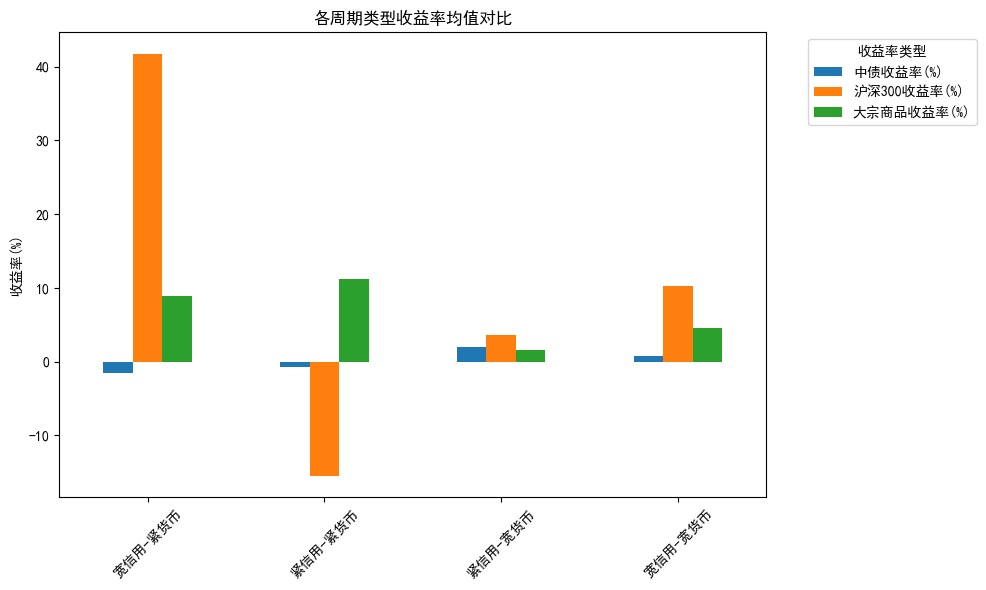

In [41]:
if mean_list:
    mean_combined = pd.DataFrame({ct: mv for ct, mv in mean_list}).T
    display(HTML("<h3>所有周期类型收益率均值汇总</h3>"))
    display(mean_combined.style.set_table_styles(table_styles).hide(axis='index'))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    mean_combined.plot(kind='bar', ax=ax)
    plt.title("各周期类型收益率均值对比")
    plt.ylabel("收益率(%)")
    plt.xticks(rotation=45)
    plt.legend(title="收益率类型", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

我们的出的结论和原报告提到的结论基本吻合：
1. 股票收益率：在“宽货币宽信用”和“紧货币宽信用”时收益率较高，其中在“紧货币宽信用”时涨幅和胜率更高。
2. 债券收益率：中枢跟随“货币周期”变化，在“宽货币”时表现更好；在同一货币周期内，“紧信用”时收益率相对更高。

但是鉴于我们的大类资产类别选择初步定为原油、黄金、铜，在测算时也使用了这三个资产（加权），没有用经典的商品指数（如南华指数），我们得到的商品收益率数据和报告并不完全吻合；后续可以再按照这个指数来测算。但是整体区间划分是差别不大的。